# Предсказание судьбы стартапов

Заказчиком предоставлены данные о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо предсказать, какие из них закроются.

**Цель исследования:**

1. Построить модель, которая сможет предсказать будущее компании на основе данных заказчика.

## Знакомство с данными

In [68]:
!pip install phik -q
!pip install scikit-learn==1.0.2 -q
import phik
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix


pd.set_option('display.max_columns', None)
plt.figure(figsize = (12,10))

TEST_SIZE = 0.25
RANDOM_STATE = 42
#STATE = np.random.RandomState(1)


<Figure size 1200x1000 with 0 Axes>

In [2]:
sample_data = pd.read_csv('D:/Data_Sciense/мастерская/kaggle_startups_sample_submit_28062024.csv')
train_data = pd.read_csv('D:/Data_Sciense/мастерская/kaggle_startups_train_28062024.csv')
test_data = pd.read_csv('D:/Data_Sciense/мастерская/kaggle_startups_test_28062024.csv')

In [3]:
sample_data.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [4]:
train_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


**Содержание датасета:**

* **name** - Название стартапа;
* **category_list** - Список категорий, к которым относится стартап;
* **funding_total_usd** - Общая сумма финансирования в USD;
* **status** - Статус стартапа (закрыт или действующий);
* **country_code** - Код страны;
* **state_code** - Код штата;
* **region** - Регион;
* **city** - Город;
* **funding_rounds** - Количество раундов финансирования;
* **founded_at** - Дата основания;
* **first_funding_at** - Дата первого раунда финансирования;
* **last_funding_at** - Дата последнего раунда финансирования;
* **closed_at** - Дата закрытия стартапа (если применимо).

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [6]:
train_data.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [7]:
test_data.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


**Содержание датасета:**

* **name** - Название стартапа;
* **category_list** - Список категорий, к которым относится стартап;
* **funding_total_usd** - Общая сумма финансирования в USD;
* **country_code** - Код страны;
* **state_code** - Код штата;
* **region** - Регион;
* **city** - Город;
* **funding_rounds** - Количество раундов финансирования;
* **first_funding_at** - Дата первого раунда финансирования;
* **last_funding_at** - Дата последнего раунда финансирования;
* **lifetime** - Время существования стартапа в днях.

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [9]:
test_data.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


**Промежуточный вывод.**

*Датасет test_data:*
* Имеет 13125 записей о стартапах и 11 колонок с описанием.
* В данных имеются пропуски в колонках: category_list, funding_total_usd, country_code, state_code, region, city.
* Половина компаний имеет только 1 раунд финансирования.

*Датасет train_data:*
* Имеет 52516 записей о стартапах и 13 колонок с описанием.
* Из колонок founded_at (Дата основания) и closed_at (Дата закрытия стартапа) можно получить колонку lifetime - Время существования стартапа в днях.
* В данных имеются пропуски в колонках: name, category_list, funding_total_usd, country_code, state_code, region, city, closed_at.

## Предобработка данных

**Проверим на дубликаты:**

In [10]:
data = [train_data, test_data]
for df in data:
    c = df.duplicated().sum()
    print(c)

0
0


In [11]:
train_data['category_list'].unique().tolist()

['Online Reservations|Restaurants',
 'Manufacturing|Medical|Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 nan,
 'Nanotechnology|Technology|Wine And Spirits',
 'Customer Service|Delivery|Retail',
 'Analytics|Cloud Data Services|Computers|Networking|Software',
 'Banking|Finance|Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z|Photo Sharing|Social Media',
 'College Recruiting|Enterprise Software|Recruiting|SaaS|Social Recruiting|Software',
 'Technology',
 'Finance|Financial Services|Payments',
 'Cloud Computing|Enterprise Resource Planning|Manufacturing|Software',
 'DIY|Environmental Innovation',
 'Entertainment|Games',
 'Internet|Pets|Services',
 'Advertising|Sales and Marketing',
 'Fitness|Sports',
 'Consumer Goods|Food Processing|Organic Food',
 'Analytics|Big Data|Business Intelligence|Marketplaces',
 'Mone

**Для обработки данных в столбце `category_list` заполним пропуски. Для этого вставим вместо пропуска название компании, т.к. большинство названий компаний совпадают с их деятельностью.**

In [12]:
train_data['category_list'] = train_data['category_list'].fillna(train_data['name'])
train_data['category_list'].isna().sum()

0

**Упростим категории компаний до более лаконичных названий:**

In [13]:
categories = {
    'restaurants': ['restaurants'],
    'medicine': ['medical', 'health care', 'health', 'pharmaceuticals', 'biotechnology', 'pharmaceuticals', 'therapeutics', 'pharm', 'Medicine',
                 'Med', 'Neurescue', 'Genetic', 'Cardio'],
    'manufacturing': ['manufacturing', 'industries', 'water purification', 'semiconductors', 'alumni', 'enterprises', 'electronics', 'industrial',
                      'oil', 'batteries', 'Solar', 'Craft Beer', 'Renewable Energies', 'Brewing', 'energy', 'Oxygen', 'Construction', 'Energies',
                      'Civil Engineers'],
    'infocommunication': ['mobile', 'internet', '3D', 'information technology', 'virtualization', 'web', 'IT', 'broadcasting', 'communications',
                          'Q&A', 'radio', 'Link', 'Google', 'MeetChina', 'Tracking', 'VoIP', 'Developer', 'Hi-Fi', 'Router', 'Service Providers',
                          'Navigation'],
    'analytics': ['analytics', 'data center', 'databases', 'search', 'machine learning', 'data', 'Big Data', 'CRM'],
    'technology': ['technology', 'apps', 'computers', 'recorder', 'Application Platforms', 'software', 'backup', 'technologies',
                   'industrial automation', 'wireless', 'iPhone', 'home automation', 'sensors', 'SaaS', 'Defense', 'Computing', 'Tech', 'Online',
                   'Hardware', 'Air Systems', 'Soft', 'innovation', 'Hardware', 'Lasers', 'Android', 'Biometrics', 'Robotics', 'Computer',
                   'Windows', 'Tracking', 'Incubators'],
    'retail': ['retail', 'sales', 'marketing', 'food', 'selling', 'commerce', 'cannabis', 'tea', 'marketplaces', 'Storage', 'Grocery', 'Water'],
    'finance': ['finance', 'banking', 'payments', 'moneymaking', 'crowdfunding', 'exchanges', 'bank', 'insurance', 'treasures', 'jewelry',
                'FinTech', 'Trading', 'Fundraising', 'E-Commerce', 'Jewel', 'Wealth', 'INVESTMENTS', 'Diamonds'],
    'messaging': ['messaging', 'networking', 'Friend', 'MailExpress', 'LetterMe', 'Network', 'Online Dating'],
    'media': ['media', 'manestreem', 'post', 'news', 'film', 'publishing', 'video', 'info', 'advertising', 'music'],
    'entertainment': ['entertainment', 'games', 'game', 'Graphics', 'Gaming', 'Gambling', 'Casino', 'Comics'],
    'environmental innovation': ['environmental innovation', 'environmental', 'Home Decor', 'Lighting', 'Landscaping'],
    'services': ['services', 'Cooking', 'Training', 'Swimming', 'Hotel', 'Hospice', 'Ticket', 'consumers', 'consumer', 'Religion', 'Wedding',
                 'Psychology'],
    'sport': ['fitness', 'sports', 'Sporting', 'Lifestyle'],
    'travel': ['travel', 'Trip', 'Tourism'],
    'pets': ['pets', 'animal', 'Veterinary'],
    'fashion': ['fashion', 'customer', 'Shopping', 'design', 'Shop', 'Textiles', 'Shoes', 'Merch'],
    'logistic': ['logistics', 'transportation', 'trans', 'Logistic', 'Delivery'],
    'B2B': ['consulting', 'outsourcing', 'human resources', 'public relations', 'Staff', 'Legal', 'Creative Agency', 'management',
            'Employment', 'B2B', 'Crowdsourcing', 'Skill Assessment'],
    'rental': ['rental', 'Office Space', 'Parking'],
    'real estate': ['real estate', 'estate', 'development', 'Home Owners'],
    'photo': ['scan', 'image', 'painter', 'photography', 'pictures', 'Printing', 'Art', 'Photo'],
    'education': ['education', 'school', 'Learning', 'EdTech', 'Academy', 'Language', 'Student'],
    'transport': ['automotive', 'bicycles', 'Aerospace', 'cars', 'Skybus', 'Taxis', 'Ship', 'Scooter', 'Vehicle'],
    'sciences': ['sciences', 'labs', 'Science'],
    'beauty': ['beauty', 'cosmetics', 'crème', 'Women', 'Hair', 'Spas'],
    'organic': ['organic', 'naturals', 'farming', 'Chemicals', 'Agriculture', 'Garden', 'Farm', 'Minerals']
}

# Функция для поиска категории по ключевым словам
def find_category(text):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                return category
    return 'no category'

# Применяем функцию к колонке 'text_column' и создаем новую колонку 'category'
train_data['category'] = train_data['category_list'].apply(find_category)

In [14]:
train_data['category'].isna().sum()

0

In [15]:
train_data = train_data.drop(columns=['category_list'])

In [16]:
train_data['status'].unique().tolist()

['operating', 'closed']

**Проделаем те же действия для датасета `test_data`:**

In [17]:
test_data['category_list'] = test_data['category_list'].fillna(test_data['name'])
test_data['category_list'].isna().sum()

0

In [18]:
test_data['category'] = test_data['category_list'].apply(find_category)

In [19]:
test_data['category'].isna().sum()

0

In [20]:
test_data = test_data.drop(columns=['category_list'])

**Заполним пропуски в столбце `funding_total_usd`. Для этого посчитаем среднюю сумму финансирования в зависимости от количества раундов финансирования:**

In [21]:
pivot_table = train_data.pivot_table(index='funding_rounds', values='funding_total_usd', aggfunc={'funding_total_usd': ['count', 'mean']})
pivot_table['mode'] = train_data.groupby('funding_rounds')['funding_total_usd'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
pivot_table['mode_count'] = train_data.groupby('funding_rounds')['funding_total_usd'].apply(
    lambda x: (x == x.mode().iloc[0]).sum() if not x.mode().empty else 0)
pivot_table

,count,mean,mode,mode_count
funding_rounds,,,,
1,24300,9.302247e+06,1.000000e+06,772
2,9110,1.358623e+07,1.000000e+06,113
3,4329,2.260116e+07,4.000000e+06,25
4,2153,3.439820e+07,1.400000e+07,8
5,1160,7.708196e+07,3.700000e+07,4
6,613,8.494351e+07,1.200000e+07,2
7,339,1.035474e+08,6.100000e+07,2
8,174,1.239461e+08,6.669530e+05,1
9,108,1.341547e+08,6.000000e+05,1


In [22]:
def fill_missing(row, pivot):
    if pd.isna(row['funding_total_usd']):
        funding_round = row['funding_rounds']
        mean_value = pivot.loc[funding_round, 'mean']
        mode_value = pivot.loc[funding_round, 'mode']
        mode_count = pivot.loc[funding_round, 'mode_count']
        if mode_count > 3:
            return mode_value
        else:
            return mean_value
    return row['funding_total_usd']

In [23]:
train_data['funding_total_usd'] = train_data.apply(lambda row: fill_missing(row, pivot_table), axis=1)
train_data['funding_total_usd'].isna().sum()

0

In [24]:
train_data['funding_total_usd'] = train_data['funding_total_usd'].astype('float32')

**Запролним пропуски и в `test_data`:**

In [25]:
test_data['funding_total_usd'] = test_data.apply(lambda row: fill_missing(row, pivot_table), axis=1)
test_data['funding_total_usd'].isna().sum()

0

In [26]:
test_data['funding_total_usd'] = test_data['funding_total_usd'].astype('float32')

In [27]:
test_data['lifetime'] = test_data['lifetime'].astype('float32')

**Проверим, сколько закрытых стартапов имеют пропуски в столбце `closed_at` таблицы `train_data`:**

In [29]:
train_data[(train_data['status'] == 'closed')&(train_data['closed_at'].isna())].shape

(0, 13)

**Т.к. мы имеем данные о стартапах с 1970 по 2018 гг., для функционирующих стартапов примем дату закрытия 2018-12-31 с целью создания столбца времени существования стартапа `lifetime` в таблице `train_data`:**

In [30]:
train_data.loc[(train_data['status'] == 'operating') & (train_data['closed_at'].isna()), 'closed_at'] = pd.to_datetime('2018-12-31')

In [31]:
train_data['closed_at'].isna().sum()

0

**Переведем значения столбцов `founded_at`, `closed_at`, `first_funding_at`, `last_funding_at` в тип datetime:**

In [32]:
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')

In [33]:
train_data['closed_at'] = pd.to_datetime(train_data['closed_at'], errors='coerce')

In [34]:
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'], errors='coerce')

In [35]:
train_data['last_funding_at'] = pd.to_datetime(train_data['last_funding_at'], errors='coerce')

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   funding_total_usd  52516 non-null  float32       
 2   status             52516 non-null  object        
 3   country_code       47014 non-null  object        
 4   state_code         45753 non-null  object        
 5   region             46157 non-null  object        
 6   city               46157 non-null  object        
 7   funding_rounds     52516 non-null  int64         
 8   founded_at         52516 non-null  datetime64[ns]
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  closed_at          52516 non-null  datetime64[ns]
 12  category           52516 non-null  object        
dtypes: datetime64[ns](4), float32(1), int64(1), object(7)
memory 

In [37]:
test_data['first_funding_at'] = pd.to_datetime(test_data['first_funding_at'], errors='coerce')

In [38]:
test_data['last_funding_at'] = pd.to_datetime(test_data['last_funding_at'], errors='coerce')

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   funding_total_usd  13125 non-null  float32       
 2   country_code       11743 non-null  object        
 3   state_code         11430 non-null  object        
 4   region             11536 non-null  object        
 5   city               11538 non-null  object        
 6   funding_rounds     13125 non-null  int64         
 7   first_funding_at   13125 non-null  datetime64[ns]
 8   last_funding_at    13125 non-null  datetime64[ns]
 9   lifetime           13125 non-null  float32       
 10  category           13125 non-null  object        
dtypes: datetime64[ns](2), float32(2), int64(1), object(6)
memory usage: 1.0+ MB


**Создадим столбец с количеством дней существования стартапа в `train_data`:**

In [40]:
train_data['lifetime'] = (train_data['closed_at'] - train_data['founded_at']).dt.days

In [41]:
train_data.head(10)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category,lifetime
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-12-31,restaurants,3362
1,EarLens,42935020.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-12-31,medicine,5112
2,Reviva Pharmaceuticals,35456380.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-12-31,medicine,4747
3,Sancilio and Company,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-12-31,medicine,5478
4,WireTough Cylinders,1000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-12-31,manufacturing,3155
5,Connected Sports Ventures,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,2018-12-31,infocommunication,2816
6,Attensity,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-12-31,medicine,6939
7,Mesh Networks,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-12-31,technology,5112
8,AngioScore,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-12-31,medicine,5843
9,Vidatronic,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-12-31,manufacturing,3286


In [42]:
train_data['lifetime'] = train_data['lifetime'].astype('float32')

**Промежуточный вывод:**

* Выполнена проверка на дубликаты;
* заполнены пропуски в category_list из столбца name;
* распределены категории деятельности стартапов на группы;
* заполнены пропуски в funding_total_usd и closed_at;
* создан столбец lifetime;
* столбцы founded_at, closed_at, first_funding_at, last_funding_at приведены к типу datetime.

## Исследовательский анализ

**Проведем анализ категориальных признаков датасета `train_data`:**

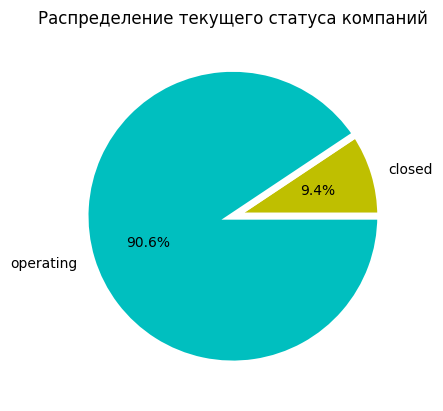

In [43]:
plt.title('Распределение текущего статуса компаний')
plt.pie(x=train_data.groupby('status')['name'].count(),
    wedgeprops={'linewidth':5, 'edgecolor':'white'},
    autopct='%1.1f%%',
    labels=train_data.groupby('status')['name'].count().index,
    colors=['y', 'c']);

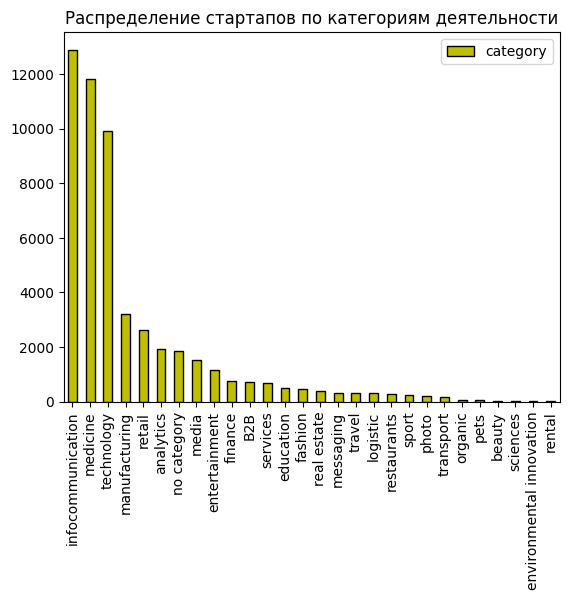

In [44]:
train_data['category'].value_counts().plot(kind='bar', label='category', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по категориям деятельности');

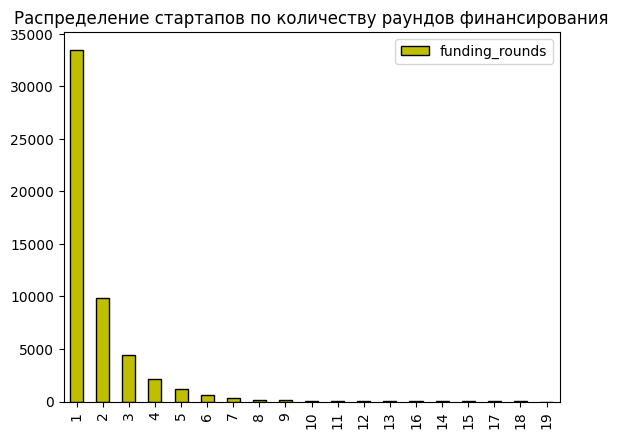

In [45]:
train_data['funding_rounds'].value_counts().head(30).plot(kind='bar', label='funding_rounds', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по количеству раундов финансирования');

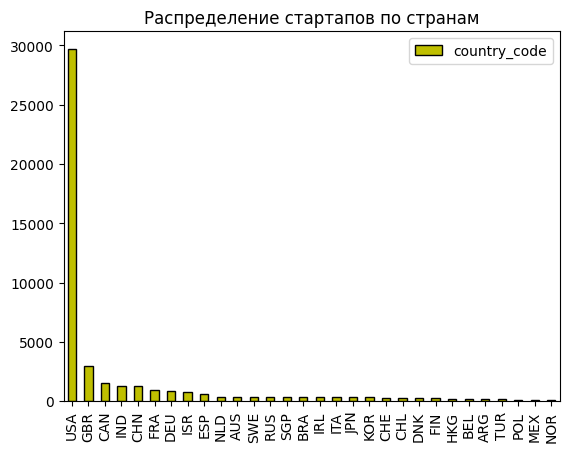

In [46]:
train_data['country_code'].value_counts().head(30).plot(kind='bar', label='country_code', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по странам');

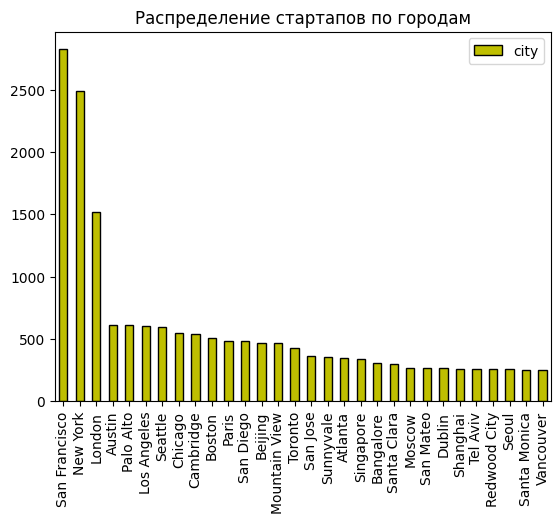

In [47]:
train_data['city'].value_counts().head(30).plot(kind='bar', label='city', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по городам');

**Более 90% стартапов продолжили свою деятельность. Большая часть стартапов провела 1 раунд финансирования. Основная масса стартапов работает в сфере медицины,инфокоммуникаций и технологий. Более половины стартапов находятся в США. Из этой страны наиболее часто встречаются стартапы из Сан-Франциско и Нью-Йорка. Также популярным городом является Лондон.**

**Посмотрим на категориальные переменные в `test_data`:**

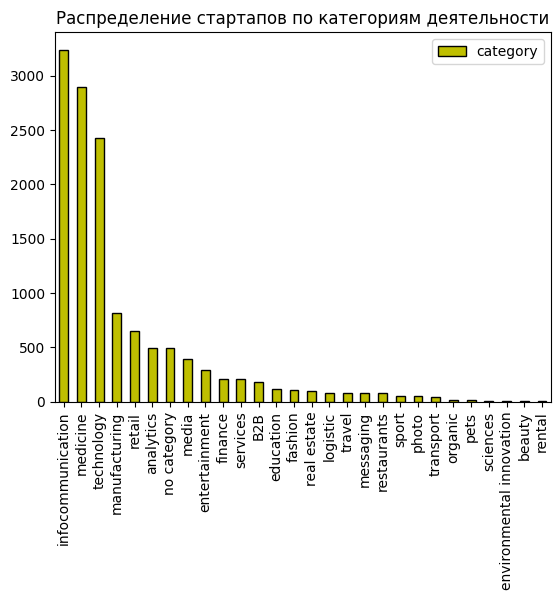

In [48]:
test_data['category'].value_counts().plot(kind='bar', label='category', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по категориям деятельности');

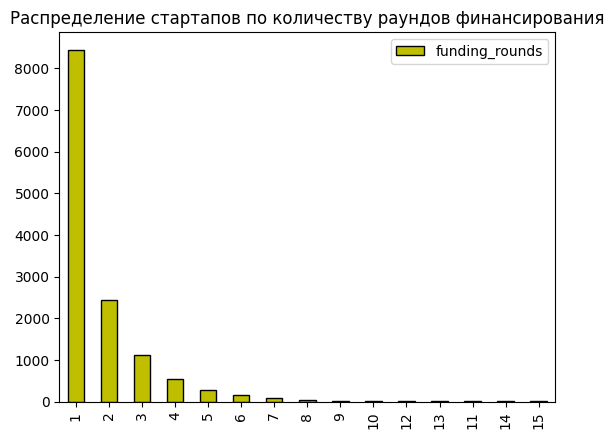

In [49]:
test_data['funding_rounds'].value_counts().head(30).plot(kind='bar', label='funding_rounds', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по количеству раундов финансирования');

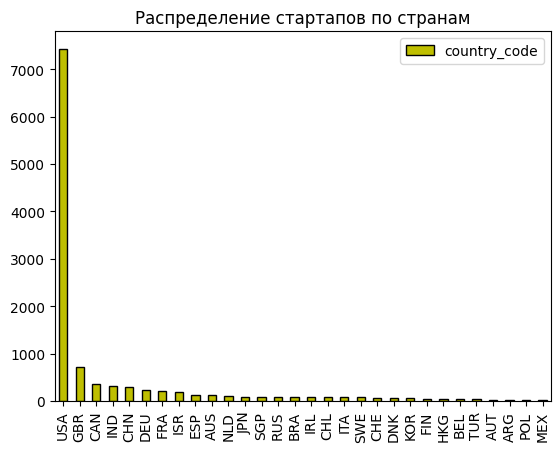

In [50]:
test_data['country_code'].value_counts().head(30).plot(kind='bar', label='country_code', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по странам');

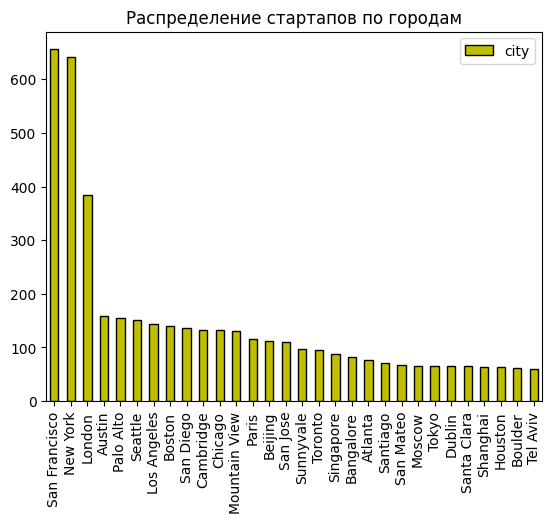

In [51]:
test_data['city'].value_counts().head(30).plot(kind='bar', label='city', color='y', ec='black')
plt.legend()
plt.title('Распределение стартапов по городам');

**Для `test_data` распределение по категориям, странам и городам примерно то же самое.**

**Перейдем к количественным признакам. Создадим универсальную функцию вывода графиков:**

In [52]:
def num_graph(data, column):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Распределение клиентов по {column}')
    plt.hist(x=data[column], histtype ='bar', bins=30, ec='black', color='c')
    plt.subplot(1, 2, 2)
    plt.xlabel(column)
    plt.title(f'Распределение клиентов по {column}')
    plt.boxplot(x=data[column])

**Для `train_data`:**

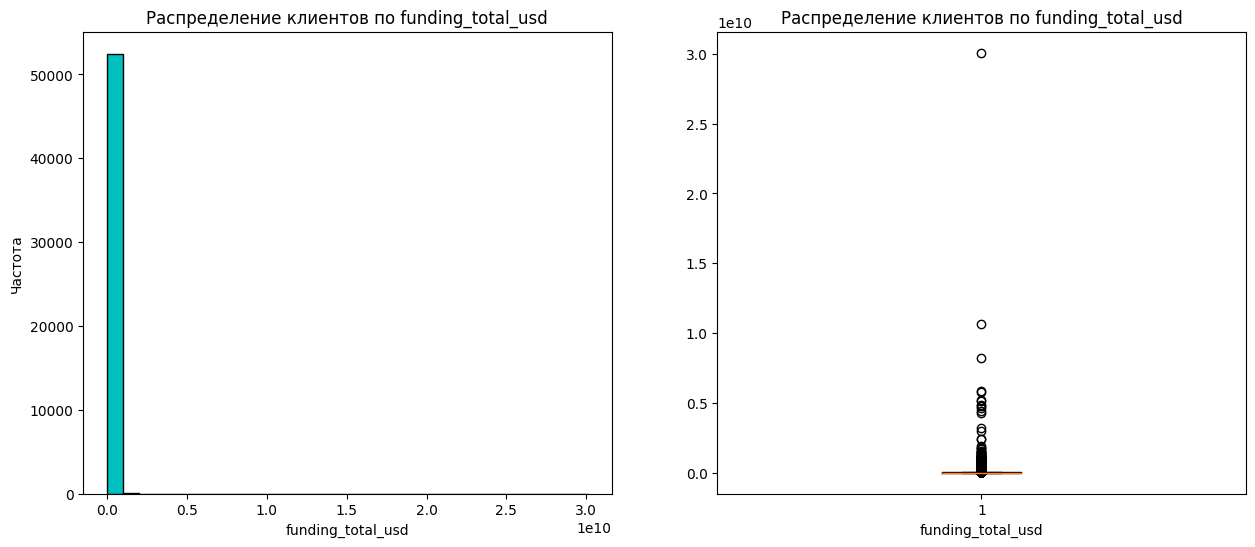

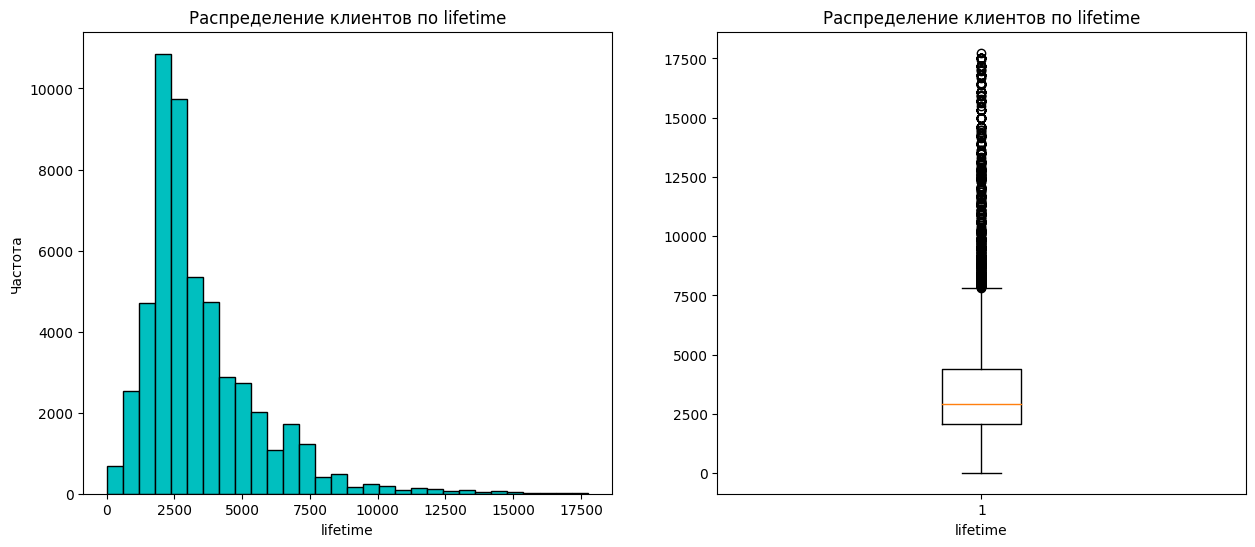

In [53]:
num_train_data = ['funding_total_usd', 'lifetime']

for num in num_train_data:
    num_graph(train_data, num)

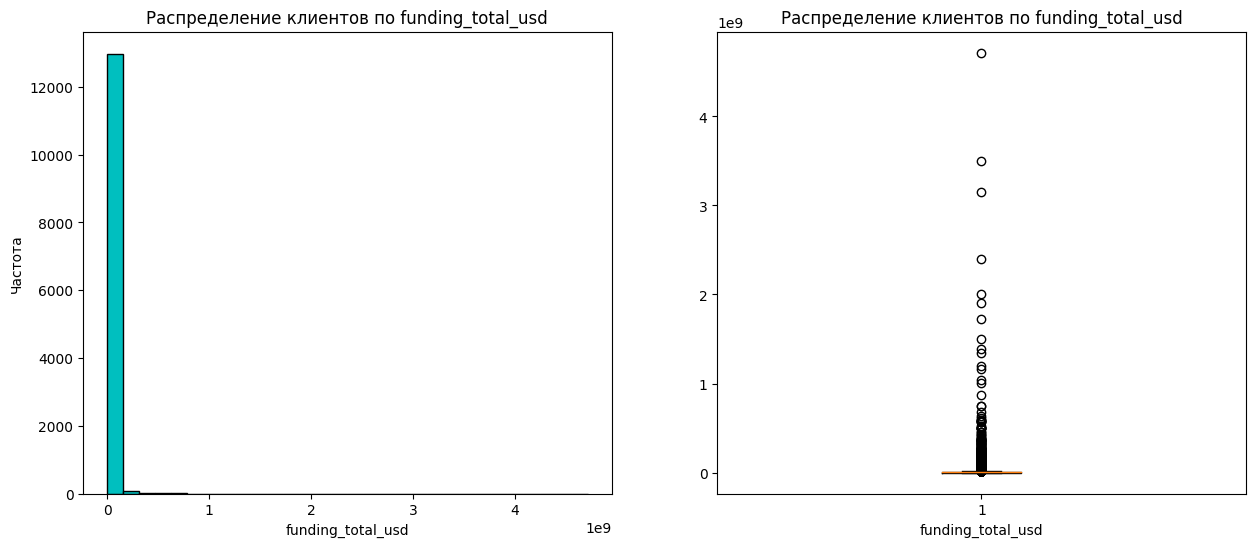

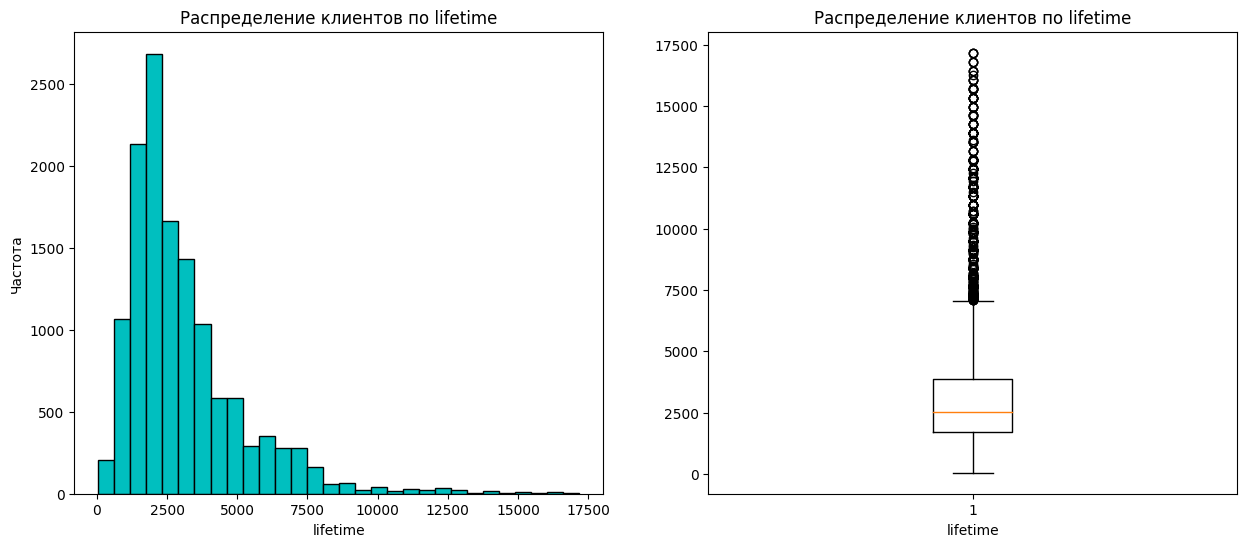

In [54]:
num_test_data = ['funding_total_usd', 'lifetime']

for num in num_test_data:
    num_graph(test_data, num)

**Датасеты имеют данные со стартапами со слишком высокой суммой финансирования, это редкие случаи, поэтому избавимся от них:**

In [55]:
train_data = train_data.query('funding_total_usd <= 100000000')
train_data.shape

(51272, 14)

In [56]:
test_data = test_data.query('funding_total_usd <= 100000000')
test_data.shape

(12837, 11)

**Убрали из датасета `train_data` 1244 стартапа, из `test_data` - 288 стартапов, построим графики снова:**

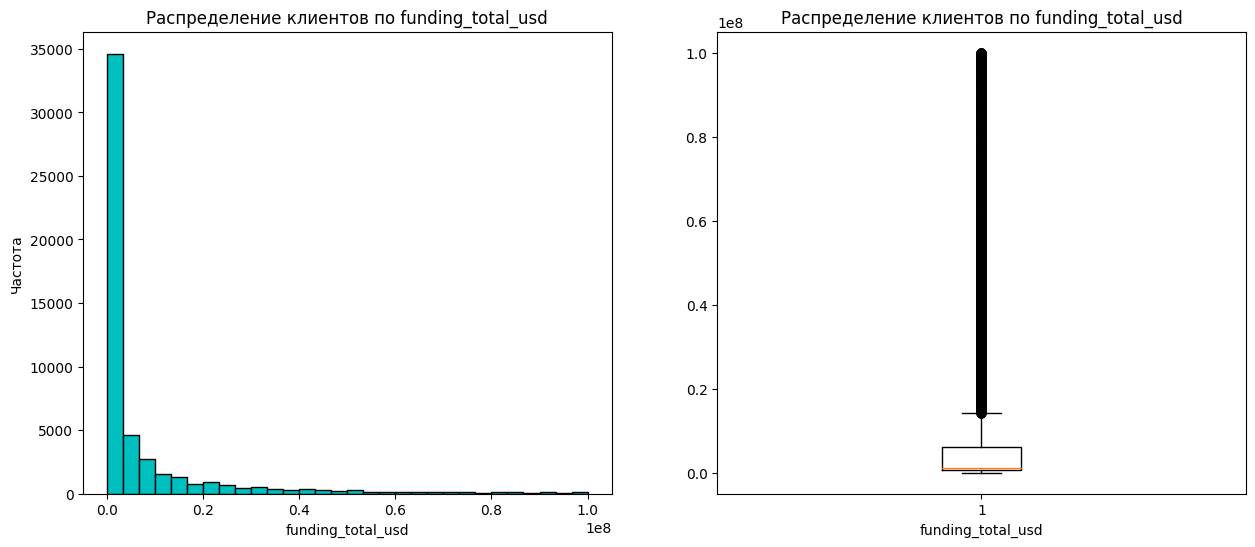

In [57]:
num_graph(train_data, 'funding_total_usd')

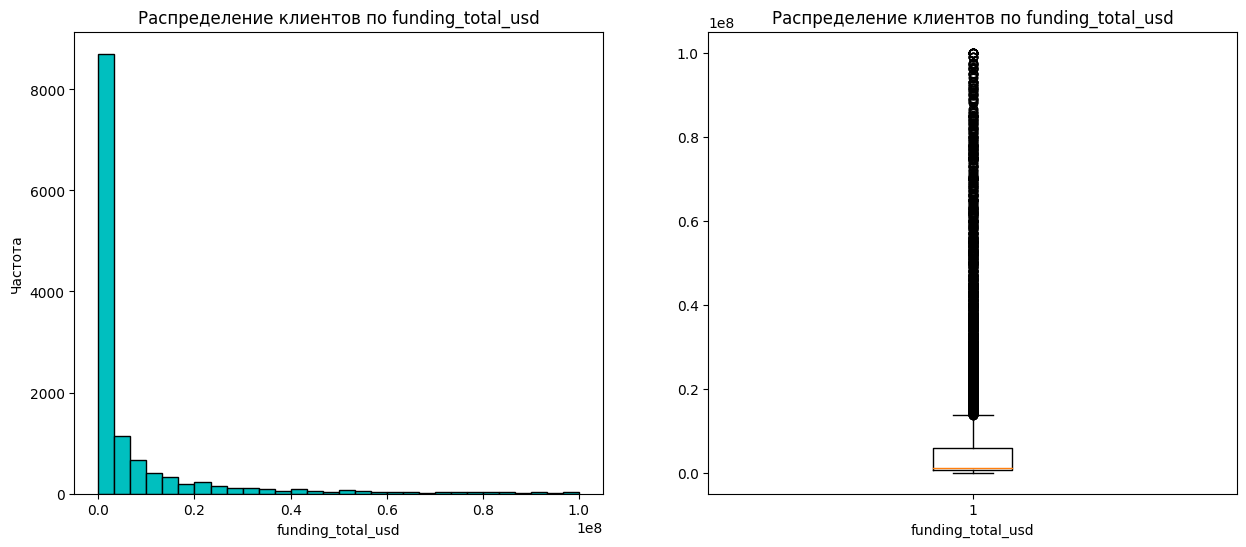

In [58]:
num_graph(test_data, 'funding_total_usd')

**Промежуточный вывод:**

* Более 90% стартапов избежали закрытия. В основном стартапы проводили один раунд финансирования. Распределения категорий деятельности стартапов и их местоположение примерно схожее в обоих датасетах.
* В графике распределения стартапов по количеству дней работы имеется пик в районе 2500 дней.
* На графике распределения сумм финансирования стартапов имелись заметные выбросы, поэтому было решено убрать случаи из датасетов.

## Корреляционный анализ

**В данных имеются категориальные признаки, а также численные признаки не распределены нормально, поэтому для проведения корреляционного анализа будем использовать phik_matrix:**

C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4449. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1032. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


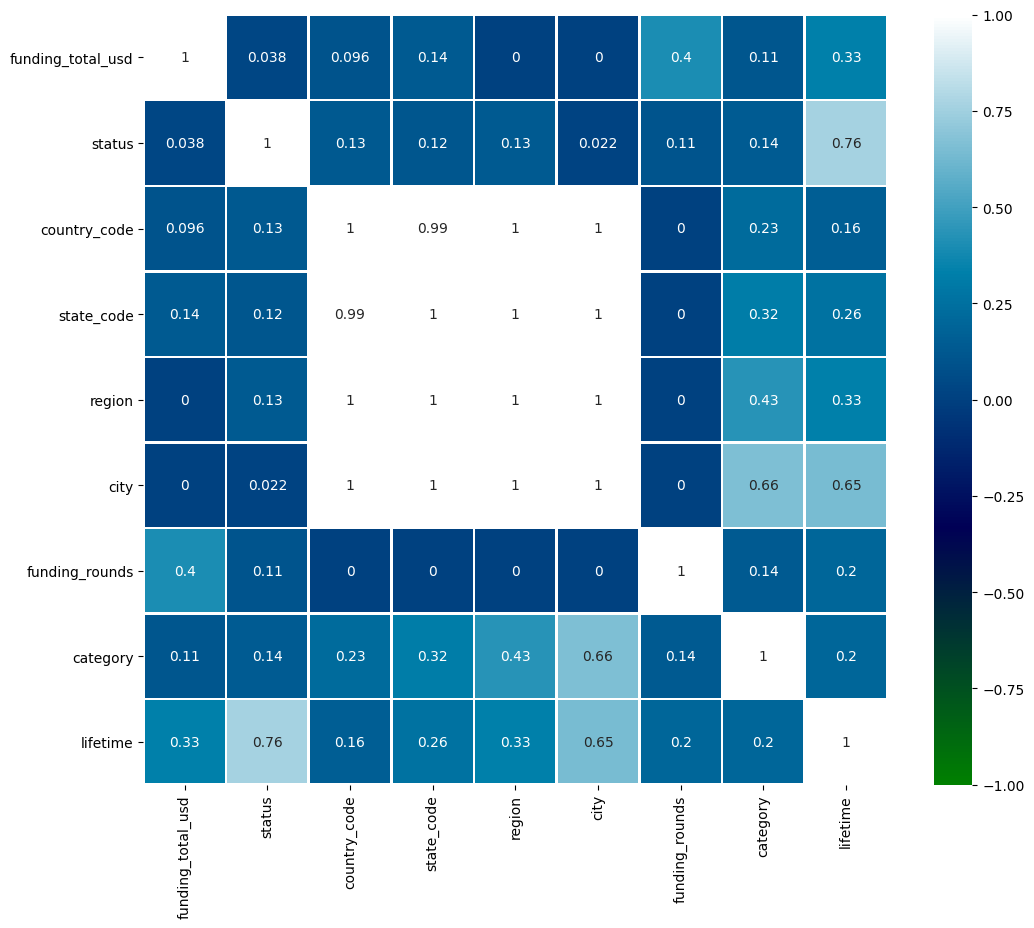

In [99]:
plt.figure(figsize = (12,10))
sns.heatmap(train_data.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)
            .phik_matrix(interval_cols=['funding_total_usd', 'lifetime']), 
            annot=True, vmin=-1, fmt='.2g', linecolor='w', linewidths=1, cmap='ocean');
plt.show();

C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 2096. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(


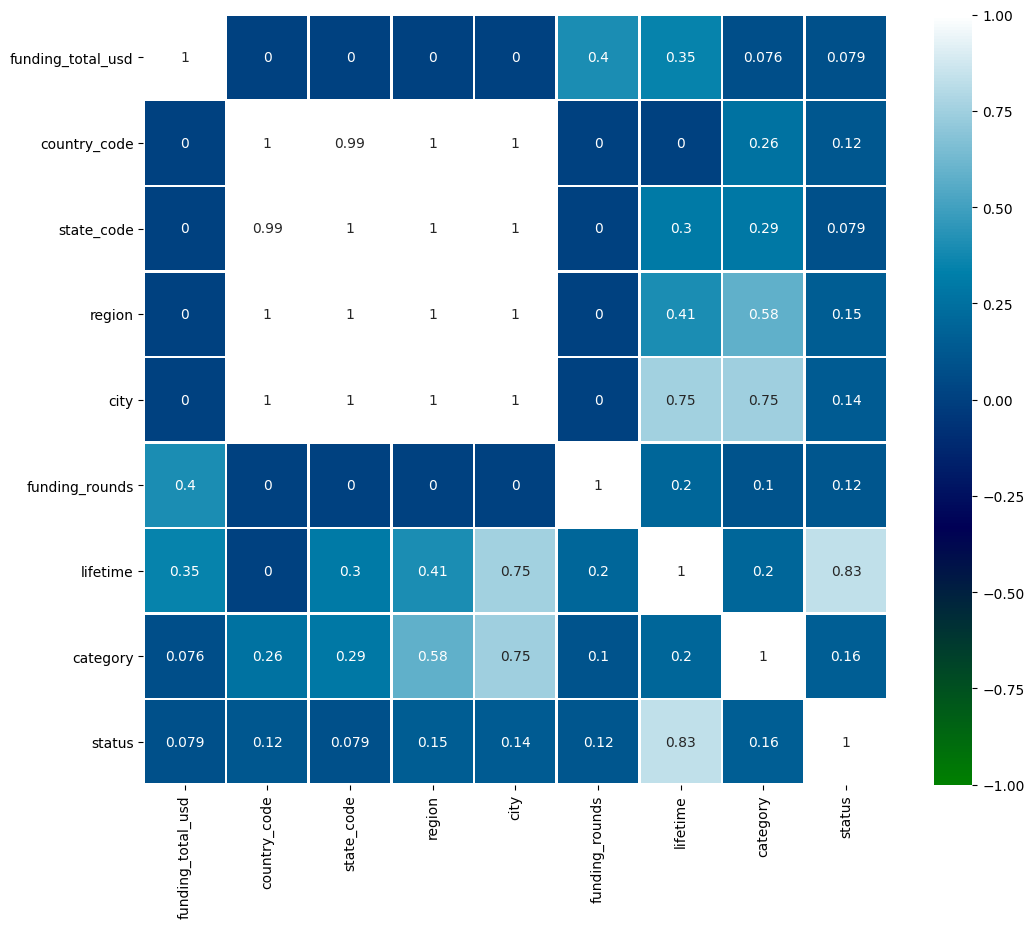

In [100]:
plt.figure(figsize = (12,10))
sns.heatmap(test_data.drop(['name', 'first_funding_at', 'last_funding_at'], axis=1)
            .phik_matrix(interval_cols=['funding_total_usd', 'lifetime']), 
            annot=True, vmin=-1, fmt='.2g', linecolor='w', linewidths=1, cmap='ocean');
plt.show();

**Целевой показатель имеет высокую корреляцию сколичеством дней существования стартапа. Общая сумма финансирования коррелирует с количеством проведенных раундов и с lifetime, чем больше раундов финансирования проводит стартап, тем выше вероятность увеличить финансирование. Также время существования компании и ее деятельность зависят от города, в котором находится стартап.**

## Обучение модели

**Разделим датасет `train_data` на тренировочную и валидационную выборки, подготовим данные к пайплайну:**

In [59]:
X = train_data.drop(['status', 'name', 'country_code', 'state_code', 'region', 'founded_at', 'first_funding_at',
                     'last_funding_at', 'closed_at'], axis = 1)
y = train_data['status']

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size = TEST_SIZE, 
                                                      random_state = RANDOM_STATE,
                                                      stratify = y)


cat_col = ['city', 'funding_rounds', 'category']
num_col = ['funding_total_usd', 'lifetime'] 

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='ignore', 
                       sparse=False))
    ]
)

num_pipe = Pipeline(
    [
        ('sImputer_nan_med', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# создаю общий пайплайн подтоговки данных
# для моделей использующих градиентный спуск и евклидово расстояние
data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_col),
        ('num', num_pipe, num_col)
    ], 
    remainder='passthrough')

In [60]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_distributions = [{
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }]

In [61]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_iter=10,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Метрика лучшей модели:\n', randomized_search.best_score_) 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)

Метрика лучшей модели:
 0.9825223943318045
Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__C': 9, 'models': SVC(C=9, probability=True, random_state=42)}


**модель метод опорных векторов показала лучший результат по метрике f1 99,81%.
Проверим модель на адекватность моделью DummyClassifier.**

In [62]:
dummy_clf = DummyClassifier(random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_valid)
dummy_f1 = f1_score(y_valid, dummy_pred)

print(f'Метрика F1 на тестовой выборке в DummyClassifier: {dummy_f1:.3f}')

Метрика F1 на тестовой выборке в DummyClassifier: 0.950


**Метрика метода опорных векторов выше, чем у дамми-классификатора, следовательно модель эффективна.**

**Выведем матрицу ошибок:**

C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


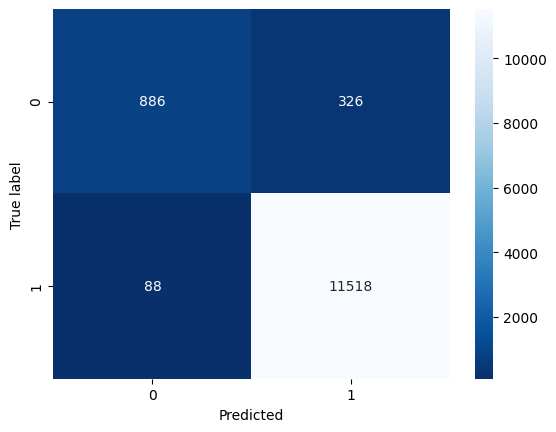

In [70]:
y_pred = randomized_search.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.ylabel('True label')
plt.xlabel('Predicted');

**Имеем 326 ошибочно-позитивных и 88 ошибочно-негативных предсказаний.**

In [80]:
X_test = test_data.drop([
    'name', 
    'country_code',
    'state_code', 
    'region',
    'first_funding_at', 
    'last_funding_at'
], axis=1)

ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

X_train_ohe = ohe_encoder.fit_transform(X_train[cat_col])
X_test_ohe = ohe_encoder.transform(X_test[cat_col])
ohe_encoder_col_names = ohe_encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train_final = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model = SVC(kernel='rbf', C=9, probability=True, random_state=42)
model.fit(X_train_final, y_train)

C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVC(C=9, probability=True, random_state=42)

**Получим список предсказанных значений:**

In [109]:
status_predictions = model.predict_proba(X_test_final)
status_predictions = (status_predictions[:, 1] < 0.74).astype(int)
status_predictions = 1 - status_predictions
status_predictions = label_encoder.inverse_transform(status_predictions)
status_predictions

array(['operating', 'operating', 'closed', ..., 'operating', 'operating',
       'closed'], dtype=object)

**Добавим столбец с полученными предсказаниями:**

In [110]:
test_data['status'] = status_predictions
test_data.head(10)

,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category,status
0,Crystalsol,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501.0,technology,operating
1,JBI Fish & Wings,1000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717.0,infocommunication,operating
2,COINPLUS,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295.0,finance,closed
3,Imagine Communications,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748.0,technology,operating
4,DNA13,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209.0,technology,operating
5,Quickfire Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583.0,entertainment,operating
6,Sente Inc.,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018.0,medicine,operating
7,Triosyn,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576.0,medicine,operating
8,Urgent.ly,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826.0,technology,closed
9,Map Decisions,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057.0,technology,operating


**Получим финальный датасет с названием компании и предсказанием:**

In [111]:
final_data = test_data[['name', 'status']]
final_data.head(10)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,operating
4,DNA13,operating
5,Quickfire Games,operating
6,Sente Inc.,operating
7,Triosyn,operating
8,Urgent.ly,closed
9,Map Decisions,operating


**Посмотрим на распределение по статусам:**

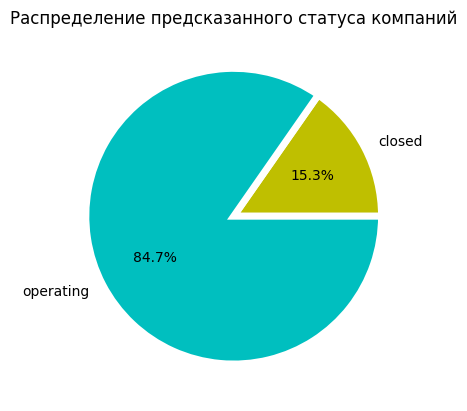

In [112]:
plt.title('Распределение предсказанного статуса компаний')
plt.pie(x=final_data.groupby('status')['name'].count(),
    wedgeprops={'linewidth':5, 'edgecolor':'white'},
    autopct='%1.1f%%',
    labels=final_data.groupby('status')['name'].count().index,
    colors=['y', 'c']);

## Вывод

**Ознакомление с данными показало:**

* набор с данными для теста test_data имеет 13125 записей о стартапах и 11 колонок с описанием. В данных имеются пропуски в колонках: category_list, funding_total_usd, country_code, state_code, region, city. Половина компаний имеет только 1 раунд финансирования.

* набор с данными для обучения модели train_data имеет 52516 записей о стартапах и 13 колонок с описанием. Из колонок founded_at (Дата основания) и closed_at (Дата закрытия стартапа) можно получить колонку lifetime - Время существования стартапа в днях. В данных имеются пропуски в колонках: name, category_list, funding_total_usd, country_code, state_code, region, city, closed_at.

**Этап предобработки данных:**

* Выполнена проверка на дубликаты;
* заполнены пропуски в category_list из столбца name;
* распределены категории деятельности стартапов на группы;
* заполнены пропуски в funding_total_usd и closed_at;
* создан столбец lifetime;
* столбцы founded_at, closed_at, first_funding_at, last_funding_at приведены к типу datetime

**Корреляционный анализ** показал высокую зависимость между целевым показателем и lifetime.
По результатам кросс-валидации **метод опорных векторов** показал лучший результат по метрике f1 99,81%. Модель предсказала всего 326 ошибочно-позитивных и 88 ошибочно-негативных ответов.

На тестовых данных получили распределение около 15% предсказания закрытия стартапов около 15% и 85% - продолжения деятельности.
Итоговый датасет с предсказаниями - `final_data`.